In [1]:
import os
import glob
import cv2
from tqdm import tqdm
import numpy as np
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
# get path to data folder
path = os.getcwd()
print(path)
data_dir = pathlib.Path.cwd()
data_train_dir = data_dir.joinpath('data','train')
data_val_dir = data_dir.joinpath('data', 'valid')
print(data_val_dir)

G:\ACM AI Project\Face_Recognition
G:\ACM AI Project\Face_Recognition\data\valid


In [3]:
# get all emotion class names
emotions = os.listdir(data_train_dir)
print(emotions)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


## Find the minimum number of images

In [4]:
num_emotion_file_arr = []

# get number of files in each emotion folders
for emotion in emotions:
    emotion_files = list(data_train_dir.glob(emotion + '/*'))
    num_emotion_file_arr.append(len(emotion_files))

print(num_emotion_file_arr)

[6566, 3231, 4859, 28592, 29384, 12223, 8113]


In [5]:
num_val_file_arr = []

# get number of files in each emotion folders
for emotion in emotions:
    emotion_files = list(data_val_dir.glob(emotion + '/*'))
    num_val_file_arr.append(len(emotion_files))

print(num_val_file_arr)

[1017, 656, 659, 5475, 5839, 2236, 1474]


In [6]:
num_files = min(num_emotion_file_arr)
print(num_files)

3231


In [7]:
num_val_files = min(num_val_file_arr)
print(num_val_files)

656


In [8]:
random_files = np.random.choice(emotion_files, num_files)
print(len(random_files))
print(str(data_train_dir.joinpath(emotion,'*')))

3231
G:\ACM AI Project\Face_Recognition\data\train\surprise\*


## Preprocess train data and validation data

### Get list of image file path and labels

In [9]:
image_files=[]
labels=[]

for emotion in emotions:
    label = emotions.index(emotion)
    
    emotion_files = glob.glob(str(data_train_dir.joinpath(emotion,'*')))
    constrained_files = np.random.choice(emotion_files, num_files)
    image_files.append(constrained_files)  
    labels.append([label]*num_files)

image_files = np.asarray(image_files)
image_files = list(image_files.flatten())
labels = np.asarray(labels)
labels = list(labels.flatten())


In [10]:
val_image_files=[]
val_labels=[]

for emotion in emotions:
    label = emotions.index(emotion)
    
    emotion_files = glob.glob(str(data_val_dir.joinpath(emotion,'*')))
    constrained_files = np.random.choice(emotion_files, num_val_files)
    val_image_files.append(constrained_files)  
    val_labels.append([label]*num_val_files)

val_image_files = np.asarray(val_image_files)
val_image_files = list(val_image_files.flatten())
val_labels = np.asarray(val_labels)
val_labels = list(val_labels.flatten())
print(len(val_image_files))

4592


### Get all images and store in tensorflow

In [11]:
batch_size = 32
img_height = 48
img_width = 48
AUTOTUNE = tf.data.AUTOTUNE

In [12]:
def parse_function(filename, label):
    image_string = tf.io.read_file(filename)

    #Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.image.decode_jpeg(image_string, channels=3)

    #This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)

    image = tf.image.resize(image, [48, 48])
    
    return image, label 

In [13]:
def train_preprocess(image, label):
    image = tf.image.random_flip_left_right(image)

    image = tf.image.random_brightness(image, max_delta=32.0 / 255.0)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)

    #Make sure the image is still in [0, 1]
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

In [14]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(len(image_files))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

In [15]:
train_ds = tf.data.Dataset.from_tensor_slices((image_files, labels))

train_ds = train_ds.map(parse_function, num_parallel_calls=4)
train_ds = train_ds.map(train_preprocess, num_parallel_calls=4)
train_ds = configure_for_performance(train_ds)

val_ds = tf.data.Dataset.from_tensor_slices((val_image_files, val_labels))
val_ds = val_ds.map(parse_function, num_parallel_calls=4)
val_ds = val_ds.map(train_preprocess, num_parallel_calls=4)
val_ds = configure_for_performance(val_ds)

In [16]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy().shape)

Image shape:  (32, 48, 48, 3)
Label:  (32,)


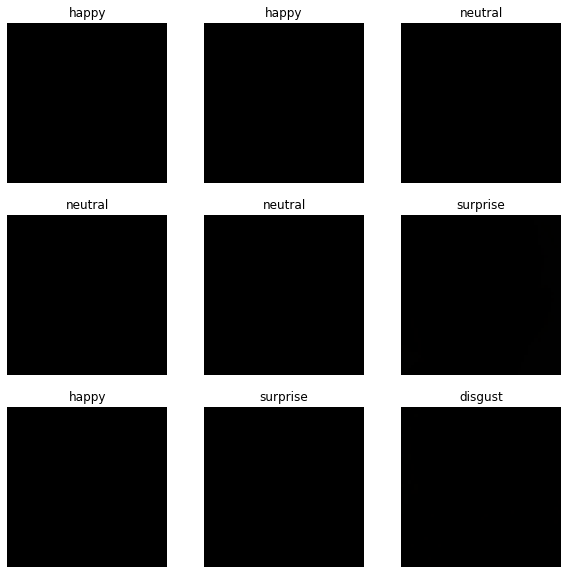

In [17]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(emotions[label])
    plt.axis("off")

### Test simple CNN model

In [18]:
num_classes = 7

model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [19]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [20]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
707/707 [==============================] - 31s 43ms/step - loss: 1.8599 - accuracy: 0.2297 - val_loss: 1.8060 - val_accuracy: 0.2646
Epoch 2/10
707/707 [==============================] - 23s 32ms/step - loss: 1.6757 - accuracy: 0.3433 - val_loss: 1.8002 - val_accuracy: 0.3084
Epoch 3/10
707/707 [==============================] - 23s 32ms/step - loss: 1.5427 - accuracy: 0.4008 - val_loss: 1.7407 - val_accuracy: 0.3249
Epoch 4/10
707/707 [==============================] - 23s 33ms/step - loss: 1.4308 - accuracy: 0.4483 - val_loss: 1.7104 - val_accuracy: 0.3434
Epoch 5/10
707/707 [==============================] - 23s 33ms/step - loss: 1.3213 - accuracy: 0.4978 - val_loss: 1.7093 - val_accuracy: 0.3458
Epoch 6/10
707/707 [==============================] - 23s 32ms/step - loss: 1.2113 - accuracy: 0.5456 - val_loss: 1.8270 - val_accuracy: 0.3341
Epoch 7/10
707/707 [==============================] - 24s 35ms/step - loss: 1.0768 - accuracy: 0.6025 - val_loss: 1.8937 - val_accuracy: